In [ ]:
import tensorflow as tf
import seaborn as sns
# Configuración de visualización
sns.set_style('whitegrid')
%matplotlib inline


print(f" TensorFlow versión: {tf.__version__}")
print(f" GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"   GPU detectada: {tf.config.list_physical_devices('GPU')}")

 TensorFlow versión: 2.19.0
 GPU disponible: False


In [ ]:
import os, tensorflow as tf
# Desactivar XLA y JIT
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
tf.config.optimizer.set_jit(False)

# OPCIONAL: Forzar CPU si sigue fallando
FORZAR_CPU = True
if FORZAR_CPU:
    try:
        dispositivos_gpu = tf.config.list_physical_devices('GPU')
        if dispositivos_gpu:
            tf.config.set_visible_devices([], 'GPU')
            print("Ejecutando en CPU (GPU deshabilitada por FORZAR_CPU).")
    except Exception as e:
        print(f" No se pudo deshabilitar GPU: {e}")

# Limpiar sesión previa
tf.keras.backend.clear_session()

La premisa fundamental de tu modelo es que una serie de tiempo financiera ($Y_t$) se compone de dos partes: una lineal (predecible por estadística clásica) y una no lineal (caótica, capturable por IA).$$Y_t = L_t + N_t$$Donde:$L_t$: Componente Lineal (Tendencia).$N_t$: Componente No Lineal (Residuo complejo).

In [ ]:
import numpy as np
import pandas as pd
import re

def cargar_datos_trm(archivo_path=None, fecha_inicio=None, fecha_fin=None):
    """
    Carga datos de TRM desde CSV con columnas:
      - periodo: entero serial de Excel (días desde 1899-12-30)
      - trm: texto con posibles separadores de miles/decimales
    Devuelve una pd.Series indexada por fecha con valores float.
    """
    if archivo_path:
        # Leer solo columnas necesarias
        df = pd.read_csv(
            archivo_path,
            encoding="latin-1",
            sep=None,
            engine="python",
            on_bad_lines="skip",
            usecols=["periodo", "trm"]
        )

        if "periodo" not in df.columns or "trm" not in df.columns:
            raise ValueError("El CSV debe contener columnas 'periodo' y 'trm'.")

        # Convertir 'periodo' (serial Excel) a datetime
        periodo_num = pd.to_numeric(df["periodo"], errors="coerce")
        base_date = pd.Timestamp(1899, 12, 30)
        df["fecha"] = base_date + pd.to_timedelta(periodo_num.fillna(0).astype(int), unit="D")

        # Limpiar y convertir 'trm' a float
        def parse_trm(x):
            if pd.isna(x):
                return np.nan
            s = str(x).strip()
            s = re.sub(r"[^0-9,.\-]", "", s)
            if "," in s and "." in s:
                s = s.replace(".", "").replace(",", ".")
            elif "," in s and "." not in s:
                s = s.replace(",", ".")
            if s.count(".") > 1:
                parts = s.split(".")
                s = "".join(parts[:-1]) + "." + parts[-1]
            return pd.to_numeric(s, errors="coerce")

        df["trm"] = df["trm"].apply(parse_trm).astype(float)

        # Limpiar filas inválidas, eliminar duplicados y ordenar
        df = df.dropna(subset=["fecha", "trm"]).set_index("fecha").sort_index()
        df = df[~df.index.duplicated(keep="first")]

        rango_min, rango_max = df.index.min(), df.index.max()

    else:
        # Datos sintéticos (solo para pruebas)
        print("⚠️ Usando datos sintéticos de prueba.")
        dates = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="B")
        n = len(dates)
        np.random.seed(42)
        trend = np.linspace(4200, 4400, n)
        noise = np.random.normal(0, 30, n)
        df = pd.DataFrame({"trm": trend + noise}, index=dates)
        rango_min, rango_max = df.index.min(), df.index.max()

    # Filtrar por fechas si se especifican
    if fecha_inicio:
        df = df[df.index >= pd.Timestamp(fecha_inicio)]
    if fecha_fin:
        df = df[df.index <= pd.Timestamp(fecha_fin)]

    if df.empty:
        raise ValueError(
            f"Sin datos tras filtrar entre {fecha_inicio} y {fecha_fin}. "
            f"Rango disponible en el CSV: {rango_min.date() if pd.notna(rango_min) else 'N/A'} a "
            f"{rango_max.date() if pd.notna(rango_max) else 'N/A'}"
        )

    # Devolver como Series limpia
    serie_trm = df["trm"]
    serie_trm.index.name = None  # opcional: quita el nombre del índice
    return serie_trm


In [ ]:
# Configuración global
CONFIG = {
    'fecha_inicio': '2023-01-20',
    'fecha_fin': '2025-11-06',
    'seed': 42
}
train = cargar_datos_trm(
    #archivo_path=None,
    archivo_path="/content/trm_to_rn.csv",
    fecha_inicio=CONFIG['fecha_inicio'],
    fecha_fin=CONFIG['fecha_fin']
)
train.head()
train = train.drop(columns=["periodo"])
train.index.name = None
train.head()

,trm
2023-01-20,4683.85
2023-01-23,4631.64
2023-01-24,4551.02
2023-01-25,4545.94
2023-01-26,4538.91


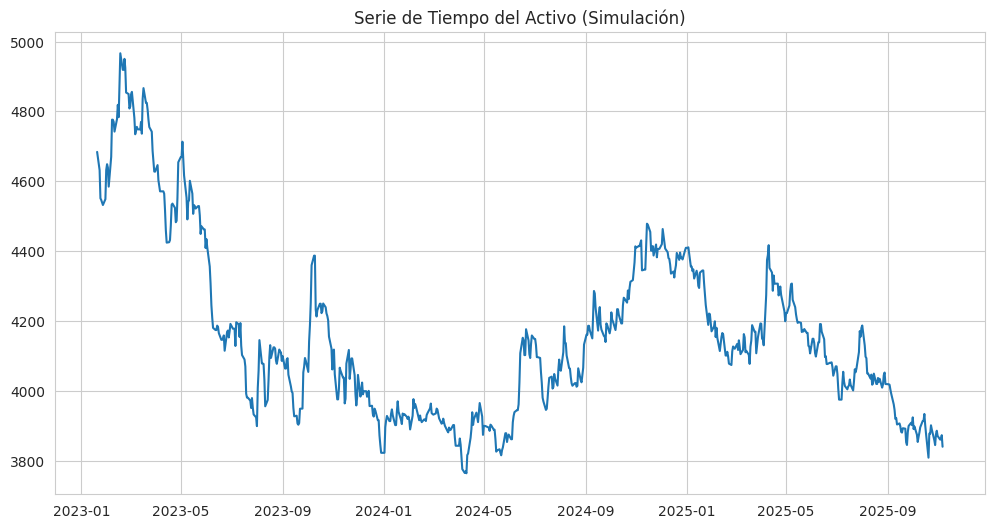

ADF Statistic: -1.9103527893769503
p-value: 0.32720661507242754
⚠️ La serie NO es estacionaria (Se requiere diferenciación)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

warnings.filterwarnings('ignore')


price_series = train
# Visualización inicial
plt.figure(figsize=(12, 6))
plt.plot(price_series)
plt.title('Serie de Tiempo del Activo (Simulación)')
plt.show()

# ---------------------------------------------------------
# 2. PRUEBA DE ESTACIONARIEDAD (Dickey-Fuller)
# ---------------------------------------------------------
# Como leímos en el artículo MDPI, ARIMA necesita series estacionarias.
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("✅ La serie es estacionaria")
    else:
        print("⚠️ La serie NO es estacionaria (Se requiere diferenciación)")

check_stationarity(price_series)

#  La Fase Lineal (ARIMA)

 usamos ARIMA para modelar la parte lineal. Al hacer el Rolling Forecast (ventana deslizante), para cada instante $t$, calculamos:$$\hat{L}_t = \text{ARIMA}(Y_{t-1}, Y_{t-2}, \dots, Y_{t-p})$$Una vez obtenemos esa predicción ($\hat{L}_t$), calculamos qué tan equivocada estuvo comparándola con el dato real. Esto genera el Residuo ($e_t$):$$e_t = Y_t - \hat{L}_t$$Nota: Este $e_t$ contiene la información que ARIMA no pudo entender (la no linealidad).

Se implementa walk-forward y Pronóstico Iterativo (Rolling Forecast) porque los datos e aplanan si entrenamos la serie de golpe

Para el día 1, usa datos reales.

Para el día 2, usa su propia predicción del día 1.

Para el día 3, usa sus predicciones del 1 y 2...

Rápidamente, el modelo "pierde confianza" y empieza a predecir simplemente el promedio de la serie (que es cercano a 0 o a esa constante debido al Z-score).
**"Ventana Deslizante" (Walk-Forward)**
**Pronóstico Iterativo (Rolling Forecast)**
https://getquipu.com/blog/rolling-forecast/

In [ ]:
diff1 = price_series.diff().dropna() # SE APLICA PRIMERA DIFERENCIA SEGUN REGLAS PACTADA
diff1_z = (diff1 - diff1.mean()) / diff1.std() # SSE APLICA ESTANDARIZACION ZSCORE SEGUN REGLAS PACTADAS

train_size = int(len(diff1_z) * 0.8)
train_data, test_data = diff1_z[0:train_size], diff1_z[train_size:]


print(f"Datos de entrenamiento: {len(train_data)}")
print(f"Datos de prueba: {len(test_data)}")


# ---------------------------------------------------------
# PASO 2: ARIMA CON WALK-FORWARD (VENTANA DESLIZANTE)
# ---------------------------------------------------------
from sklearn.metrics import mean_squared_error

# 1. Preparamos el historial inicial con los datos de entrenamiento
history = [x for x in train_data]
predictions = []
expected_values = [x for x in test_data]

print(f"Iniciando predicción iterativa para {len(test_data)} días...")

# 2. Bucle de Walk-Forward Entrenamiento OUTSAMPLE
# Por cada día en el set de prueba:
for t in range(len(test_data)):
    # a. Entrenamos el modelo con la historia disponible hasta HOY
    #    (Para optimizar velocidad, en datasets gigantes se usa 'append' o retrain cada X días,
    #     pero aquí re-entrenaremos para máxima precisión)
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()

    # b. Predecimos SOLAMENTE el siguiente día (step=1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    # c. Observamos el dato Real y lo agregamos al historial para la predicción de mañana
    obs = expected_values[t]
    history.append(obs)

    # Opcional: Imprimir progreso cada 50 días
    if t % 50 == 0:
        print(f"Día {t}: Pred={yhat:.4f}, Real={obs:.4f}")


model_arima = ARIMA(train_data, order=(1, 0, 0))
model_fit = model_arima.fit()

# Generamos predicciones
# a) Predicción sobre el conjunto de entrenamiento (In-sample) para obtener residuos de entrenamiento
train_arima_pred = model_fit.fittedvalues



Datos de entrenamiento: 583
Datos de prueba: 146
Iniciando predicción iterativa para 146 días...
Día 0: Pred=0.2592, Real=-0.6806
Día 50: Pred=0.0169, Real=-0.3786
Día 100: Pred=0.0025, Real=-0.3961


In [ ]:
# 3. Convertimos a Series de Pandas para mantener índices
test_arima_pred = pd.Series(predictions, index=test_data.index)

# 4. Recalculamos Residuos (AHORA SÍ SERÁN VÁLIDOS)
# Nota: train_resid lo calculamos "in-sample" como antes, eso estaba bien.
# Lo que cambia es test_resid.

train_resid = train_data - train_arima_pred
test_resid = test_data - test_arima_pred




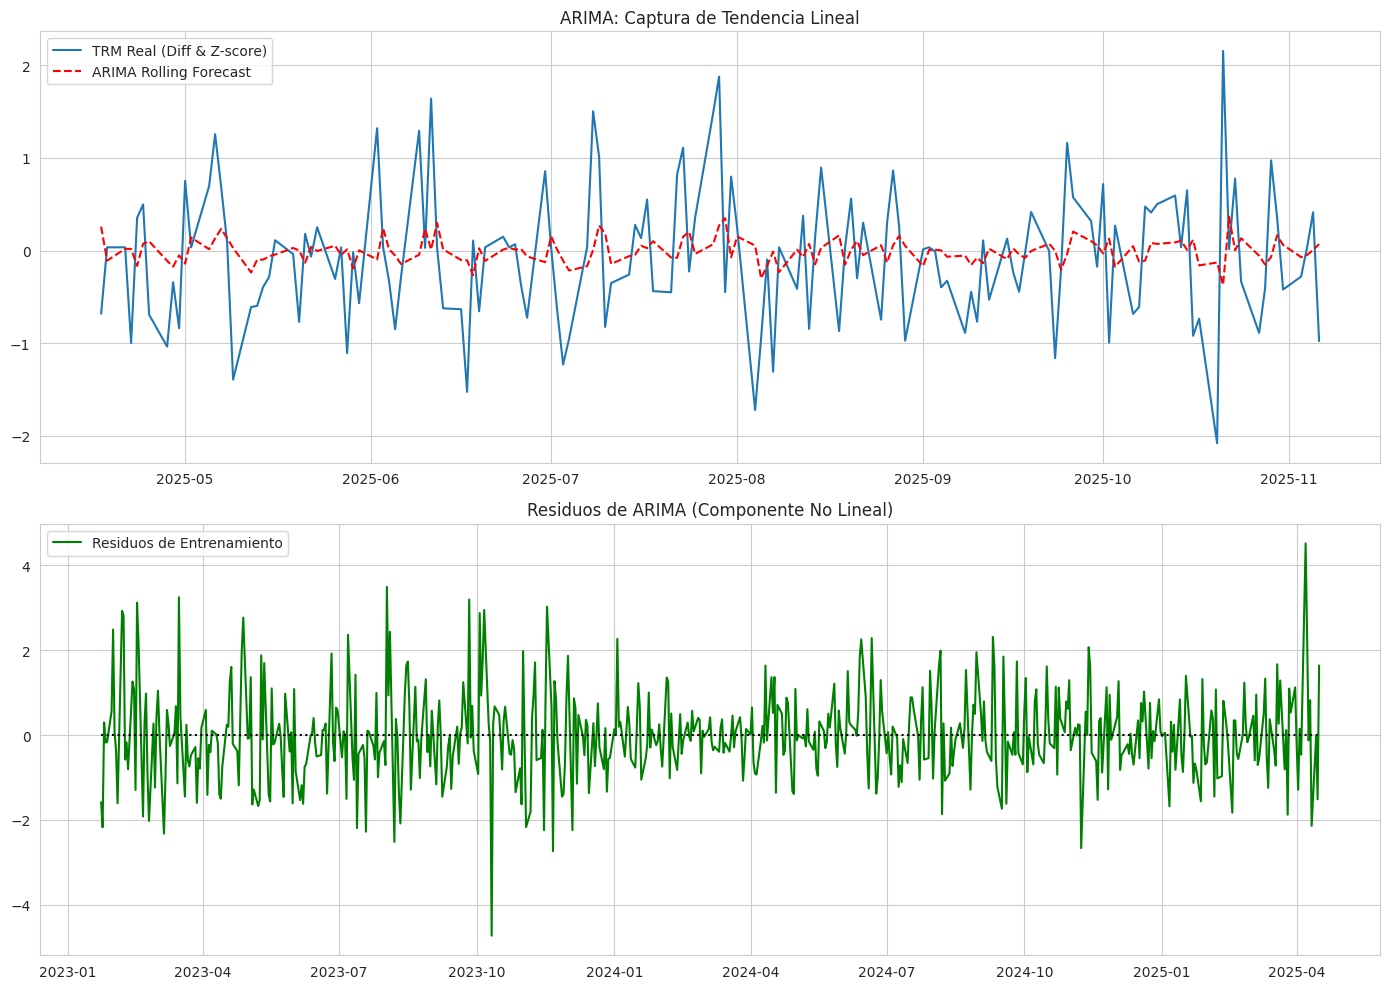

MSE de ARIMA (Solo parte lineal): 0.5255


In [ ]:

# Visualización de lo que hemos hecho
plt.figure(figsize=(14, 10))

# Gráfica 1: ARIMA vs Realidad (Test set)
plt.subplot(2, 1, 1)
plt.plot(test_data, label='TRM Real (Diff & Z-score)')
plt.plot(test_arima_pred, color='red', linestyle='--', label='ARIMA Rolling Forecast')
plt.title('ARIMA: Captura de Tendencia Lineal')
plt.legend()

# Gráfica 2: Los Residuos (Lo que aprenderá la LSTM)
plt.subplot(2, 1, 2)
plt.plot(train_resid, color='green', label='Residuos de Entrenamiento')
plt.hlines(0, train_resid.index[0], train_resid.index[-1], colors='black', linestyles='dotted')
plt.title('Residuos de ARIMA (Componente No Lineal)')
plt.legend()

plt.tight_layout()
plt.show()

# Métricas base solo de ARIMA
arima_mse = mean_squared_error(test_data, test_arima_pred)
print(f"MSE de ARIMA (Solo parte lineal): {arima_mse:.4f}")

In [ ]:

look_back = 60

# ==============================================================================
# FASE A: PREPARACIÓN DE LOS NUEVOS DATOS (Con Residuos Correctos)
# ==============================================================================

# 1. Calcular los nuevos residuos de prueba (usando el ARIMA Rolling Forecast que acabamos de hacer)
# Asegúrate de que 'test_arima_pred' venga del bucle for del paso anterior
test_resid = test_data - test_arima_pred

# 2. Limpieza y Escalado
# train_resid sigue siendo el mismo (in-sample), test_resid es el nuevo
train_resid = train_resid.dropna()
test_resid = test_resid.dropna()

train_resid_values = train_resid.values.reshape(-1, 1)
test_resid_values = test_resid.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
# Ajustamos scaler solo con train
scaled_train = scaler.fit_transform(train_resid_values)
scaled_test = scaler.transform(test_resid_values)

def create_dataset(dataset, look_back=50):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(scaled_train, look_back)
X_test, y_test = create_dataset(scaled_test, look_back)


# Reshape para LSTM [Muestras, Pasos, Características]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



## La Fase No Lineal (Stacked LSTM)
Aquí es donde entra tu red neuronal. Tomamos la secuencia de errores pasados y tratamos de predecir el error futuro.Tu modelo LSTM de dos capas funciona como una función compuesta:$$h_t^{(1)} = \text{LSTM}_1(e_{t-1}, e_{t-2}, \dots, e_{t-60})$$$$h_t^{(2)} = \text{LSTM}_2(h_t^{(1)})$$$$\hat{N}_t = \text{Dense}(h_t^{(2)})$$Donde:$e_{t-k}$: Son los residuos pasados (ventana de 60 días).$\text{LSTM}_1$: Primera capa (30 neuronas) extrae características generales.$\text{LSTM}_2$: Segunda capa (20 neuronas) refina la predicción.$\hat{N}_t$: Es la predicción del residuo para el tiempo $t$.

🚀 Iniciando entrenamiento extendido (Max 500 épocas)...
Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1875 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0693 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0606 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0511 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0511 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0445 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0431 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0412 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 9/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.03

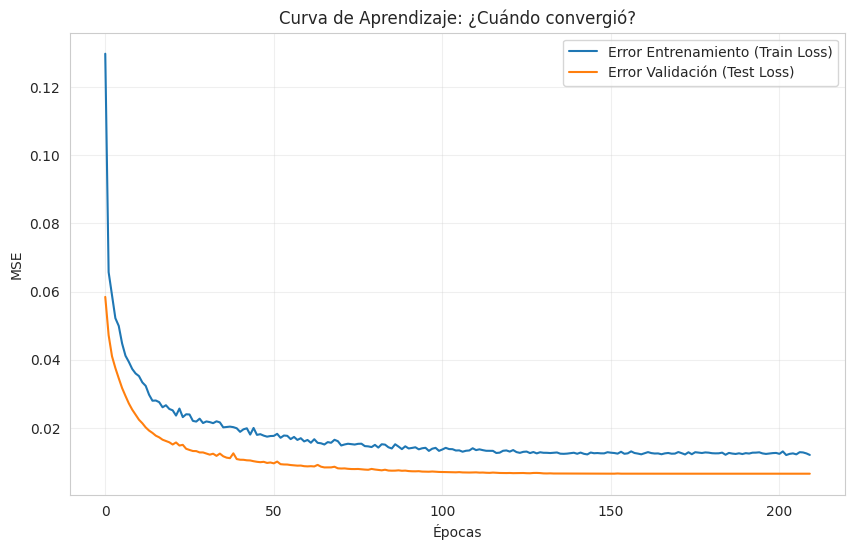

🛑 Entrenamiento detenido en la época: 210
✅ Mejor Loss de Validación alcanzado: 0.006574


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================================
# CONFIGURACIÓN "DEJA QUE APRENDA"
# ==========================================
# Aumentamos drásticamente el límite de épocas
EPOCHS_MAX = 500

# Paciencia Alta: Esperará 30 épocas sin mejora antes de rendirse.
# Esto permite que la red supere "mesetas" temporales.
PATIENCE = 30

# Arquitectura Ajustada (La que tenías, pero optimizada)
model_lstm = Sequential()

# Capa 1: LSTM con Regularización suave
model_lstm.add(LSTM(units=32,
               return_sequences=True,
               input_shape=(look_back, 1),
               kernel_regularizer=l2(0.001))) # L2 suave para permitir aprendizaje
model_lstm.add(Dropout(0.2))

# Capa 2: LSTM
model_lstm.add(LSTM(units=16,
               return_sequences=False,
               kernel_regularizer=l2(0.001)))
model_lstm.add(Dropout(0.2))

# Salida directa
model_lstm.add(Dense(1))

# ==========================================
# CALLBACKS INTELIGENTES
# ==========================================
# 1. EarlyStopping: Se detiene si val_loss no mejora en 'patience' épocas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True, # ¡Vital! Al final regresa al mejor punto, no al último.
    verbose=1
)

# 2. ReduceLROnPlateau: Si se estanca, reduce la velocidad de aprendizaje
# para intentar "aterrizar" suavemente en el mínimo error.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Reduce el LR a la mitad
    patience=10,      # Si en 10 épocas no mejora
    min_lr=1e-6,
    verbose=1
)

# Compilación
optimizer_conf = Adam(learning_rate=0.001) # Empezamos un poco más rápido
model_lstm.compile(optimizer=optimizer_conf, loss='mean_squared_error')

print(f"🚀 Iniciando entrenamiento extendido (Max {EPOCHS_MAX} épocas)...")

# Entrenamiento
history = model_lstm.fit(
    X_train, y_train,
    epochs=EPOCHS_MAX,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr], # Agregamos los callbacks
    verbose=1
)

# ==========================================
# VISUALIZACIÓN DEL PROCESO
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Error Entrenamiento (Train Loss)')
plt.plot(history.history['val_loss'], label='Error Validación (Test Loss)')
plt.title('Curva de Aprendizaje: ¿Cuándo convergió?')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Imprimir en qué época se detuvo realmente
print(f"🛑 Entrenamiento detenido en la época: {len(history.history['loss'])}")
print(f"✅ Mejor Loss de Validación alcanzado: {min(history.history['val_loss']):.6f}")

## La Predicción Híbrida FinalFinalmente,
sumamos las dos predicciones para obtener el valor ajustado. Corregimos la tendencia de ARIMA con la intuición de la LSTM.$$\hat{Y}_{final, t} = \hat{L}_t + \hat{N}_t$$

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step

 RESULTADOS FINALES (METODOLOGÍA CORRECTA)
MSE Modelo ARIMA (Base):  0.546760
MSE Modelo Híbrido:       0.545568
✅ ÉXITO: El modelo híbrido mejoró la predicción en un 0.22%


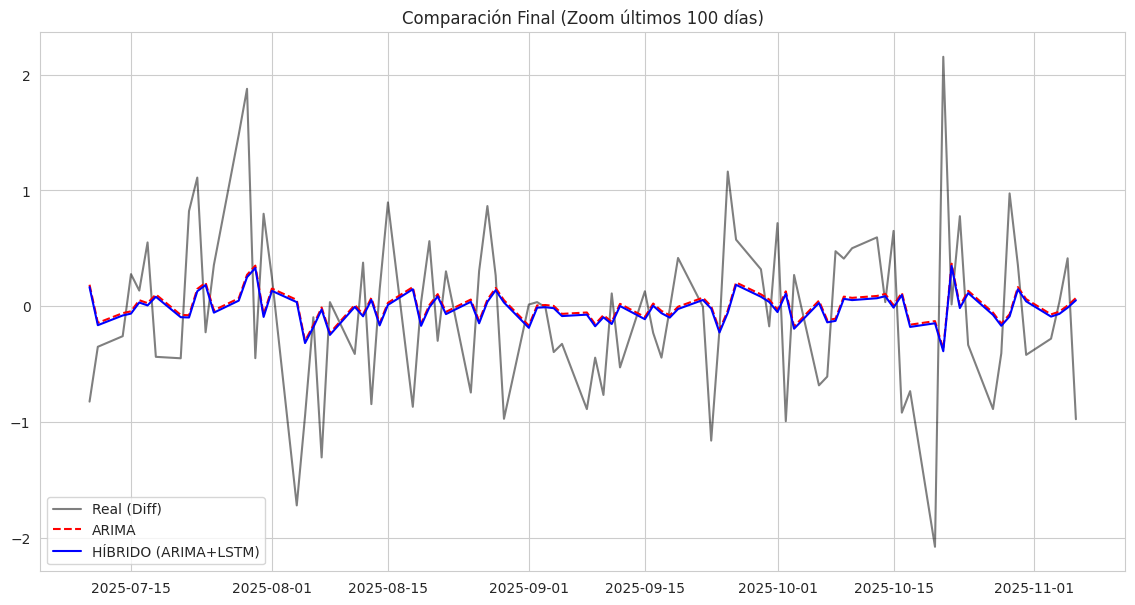

In [ ]:
# ==============================================================================
# FASE C: PREDICCIÓN HÍBRIDA Y EVALUACIÓN
# ==============================================================================

# 1. Predecir residuos con la LSTM entrenada
lstm_pred_scaled = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
# 2. Alinear dimensiones (Recortar los primeros 'look_back' días)
# ARIMA Rolling también debe recortarse para coincidir con la salida de LSTM
arima_pred_aligned = test_arima_pred.iloc[look_back:]
real_data_aligned = test_data.iloc[look_back:]

# Asegurar que índices coinciden
arima_values = arima_pred_aligned.values
lstm_values = lstm_pred.flatten()

# 3. ¡LA FUSIÓN! (Suma: Lineal + No Lineal)
hybrid_prediction = arima_values + lstm_values

# 4. Métricas Finales
mse_arima = mean_squared_error(real_data_aligned, arima_values)
mse_hybrid = mean_squared_error(real_data_aligned, hybrid_prediction)

print("\n" + "="*40)
print(" RESULTADOS FINALES (METODOLOGÍA CORRECTA)")
print("="*40)
print(f"MSE Modelo ARIMA (Base):  {mse_arima:.6f}")
print(f"MSE Modelo Híbrido:       {mse_hybrid:.6f}")

mejora = ((mse_arima - mse_hybrid) / mse_arima) * 100
if mejora > 0:
    print(f"✅ ÉXITO: El modelo híbrido mejoró la predicción en un {mejora:.2f}%")
else:
    print(f"⚠️ RESULTADO: El híbrido aumentó el error en {abs(mejora):.2f}%")
    print("   (Esto sugiere que los residuos son puramente aleatorios/ruido blanco)")

# 5. Gráfico de Comparación (Solo los últimos 100 días para ver detalle)
plt.figure(figsize=(14, 7))
plt.plot(real_data_aligned.index[-100:], real_data_aligned.values[-100:], label='Real (Diff)', color='black', alpha=0.5)
plt.plot(real_data_aligned.index[-100:], arima_values[-100:], label='ARIMA', color='red', linestyle='--')
plt.plot(real_data_aligned.index[-100:], hybrid_prediction[-100:], label='HÍBRIDO (ARIMA+LSTM)', color='blue', linewidth=1.5)
plt.title('Comparación Final (Zoom últimos 100 días)')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def auditar_residuos(residuos):
    residuos = np.array(residuos).flatten()

    print("🔎 --- AUDITORÍA DE RESIDUOS (ARIMA) --- 🔎\n")

    # -------------------------------------------------------
    # 1. AUTOCORRELACIÓN (¿Es Ruido Blanco?)
    # -------------------------------------------------------
    print("1️⃣  Autocorrelación (Test Ljung-Box)")
    # H0: Los datos se distribuyen de forma independiente (Es ruido blanco)
    # H1: Hay correlación serial (El modelo dejó patrones)

    lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
    p_val_lb = lb_test['lb_pvalue'].values[0]

    print(f"   P-value Ljung-Box: {p_val_lb:.5f}")
    if p_val_lb < 0.05:
        print("   ❌ RESULTADO: Se rechaza H0. Hay autocorrelación.")
        print("   👉 INTERPRETACIÓN: Queda información lineal/no-lineal por explotar (¡Bien para LSTM!).")
    else:
        print("   ✅ RESULTADO: No se rechaza H0. Es ruido blanco.")
        print("   👉 INTERPRETACIÓN: El ARIMA capturó todo lo temporal.")

    # Gráfica ACF
    plt.figure(figsize=(10, 4))
    plot_acf(residuos, lags=20, title='Autocorrelación de Residuos')
    plt.show()

    # -------------------------------------------------------
    # 2. NORMALIDAD (¿Campana de Gauss?)
    # -------------------------------------------------------
    print("\n2️⃣  Normalidad (Test Jarque-Bera)")
    # H0: Los datos siguen una distribución normal
    # H1: Los datos NO son normales

    stat_jb, p_val_jb = stats.jarque_bera(residuos)

    print(f"   P-value Jarque-Bera: {p_val_jb:.5f}")
    if p_val_jb < 0.05:
        print("   ❌ RESULTADO: Se rechaza H0. Los residuos NO son normales.")
        print("   👉 Causa probable: Colas pesadas (shocks extremos típicos en TRM).")
    else:
        print("   ✅ RESULTADO: Residuos normales.")

    # Histograma y QQ-Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].hist(residuos, bins=30, density=True, alpha=0.6, color='g')
    xmin, xmax = ax[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(residuos), np.std(residuos))
    ax[0].plot(x, p, 'k', linewidth=2)
    ax[0].set_title("Histograma vs Normal")

    stats.probplot(residuos, dist="norm", plot=ax[1])
    ax[1].set_title("Q-Q Plot")
    plt.show()

    # -------------------------------------------------------
    # 3. HOMOCEDASTICIDAD (Test ARCH)
    # -------------------------------------------------------
    print("\n3️⃣  Homocedasticidad (Test de Engle - ARCH)")
    # H0: La varianza es constante (Homocedasticidad)
    # H1: La varianza cambia con el tiempo (Heterocedasticidad / Volatilidad)

    test_arch = het_arch(residuos)
    p_val_arch = test_arch[1] # El p-value del test LM

    print(f"   P-value ARCH: {p_val_arch:.5f}")
    if p_val_arch < 0.05:
        print("   ❌ RESULTADO: Se rechaza H0. Hay efectos ARCH (Volatilidad agrupada).")
        print("   👉 INTERPRETACIÓN: El riesgo cambia por épocas. ARIMA falla aquí, LSTM debe corregirlo.")
    else:
        print("   ✅ RESULTADO: Varianza constante.")




 AUDITORÍA 1: MODELO ARIMA (SOLO)
🔎 --- AUDITORÍA DE RESIDUOS (ARIMA) --- 🔎

1️⃣  Autocorrelación (Test Ljung-Box)
   P-value Ljung-Box: 0.59249
   ✅ RESULTADO: No se rechaza H0. Es ruido blanco.
   👉 INTERPRETACIÓN: El ARIMA capturó todo lo temporal.


<Figure size 1000x400 with 0 Axes>

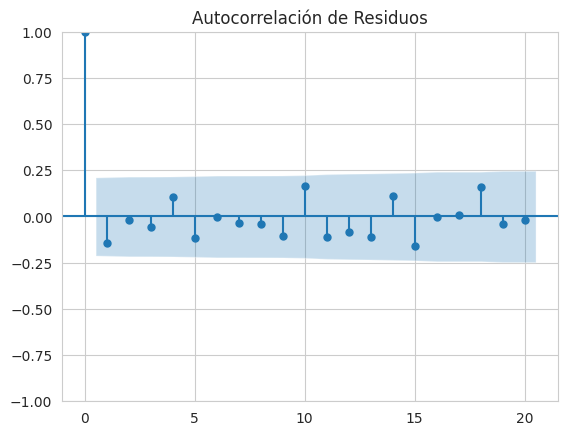


2️⃣  Normalidad (Test Jarque-Bera)
   P-value Jarque-Bera: 0.13835
   ✅ RESULTADO: Residuos normales.


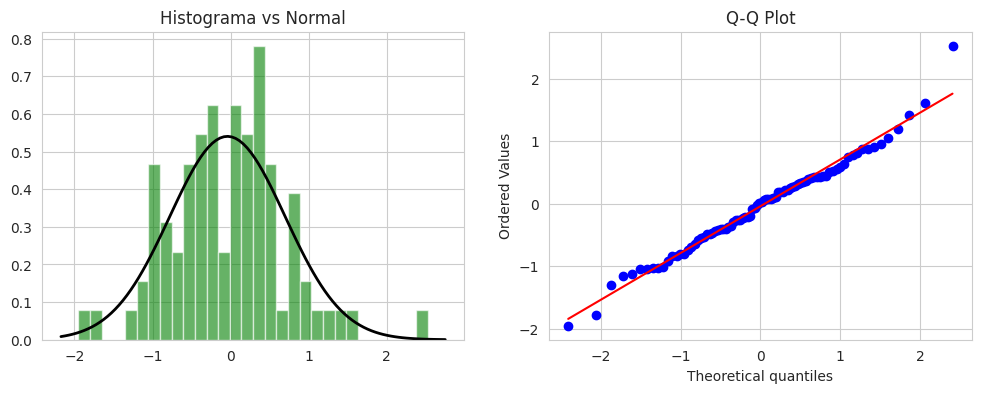


3️⃣  Homocedasticidad (Test de Engle - ARCH)
   P-value ARCH: 0.84287
   ✅ RESULTADO: Varianza constante.

 AUDITORÍA 2: MODELO HÍBRIDO (ARIMA + LSTM)
🔎 --- AUDITORÍA DE RESIDUOS (ARIMA) --- 🔎

1️⃣  Autocorrelación (Test Ljung-Box)
   P-value Ljung-Box: 0.59458
   ✅ RESULTADO: No se rechaza H0. Es ruido blanco.
   👉 INTERPRETACIÓN: El ARIMA capturó todo lo temporal.


<Figure size 1000x400 with 0 Axes>

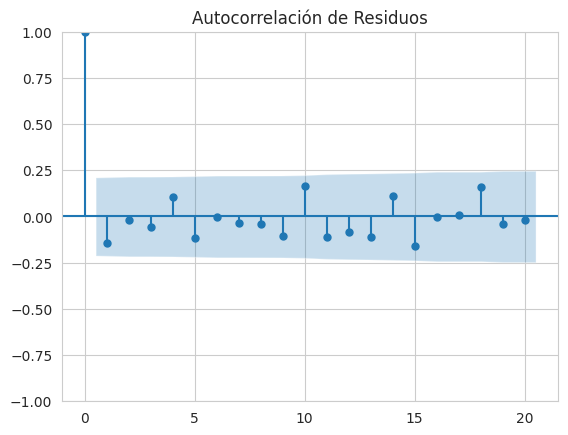


2️⃣  Normalidad (Test Jarque-Bera)
   P-value Jarque-Bera: 0.13956
   ✅ RESULTADO: Residuos normales.


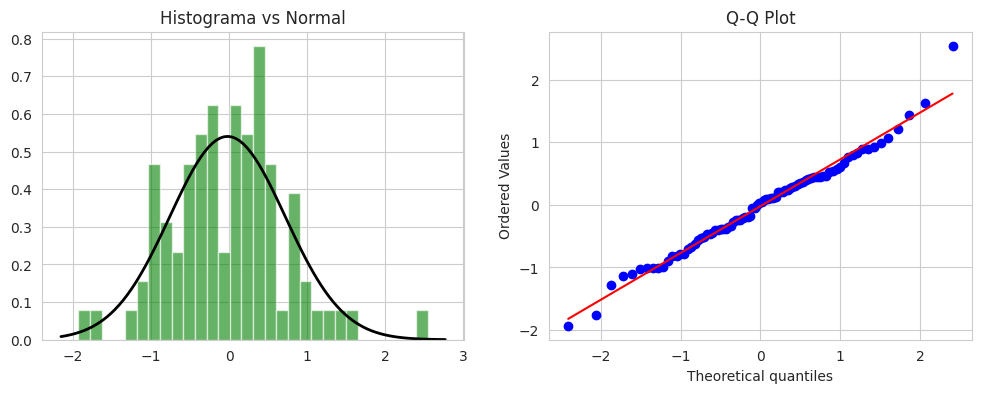


3️⃣  Homocedasticidad (Test de Engle - ARCH)
   P-value ARCH: 0.84427
   ✅ RESULTADO: Varianza constante.


In [ ]:
# 1. Definir los residuos completos alineados (Todo el test set, no solo 100)
# (Asegúrate de que arima_values y hybrid_prediction tengan el mismo largo)
residuos_arima_full = real_data_aligned.values - arima_values.flatten()
residuos_hibrido_full = real_data_aligned.values - hybrid_prediction.flatten()

print("\n" + "="*50)
print(" AUDITORÍA 1: MODELO ARIMA (SOLO)")
print("="*50)
auditar_residuos(residuos_arima_full)

print("\n" + "="*50)
print(" AUDITORÍA 2: MODELO HÍBRIDO (ARIMA + LSTM)")
print("="*50)
auditar_residuos(residuos_hibrido_full)